<a href="https://colab.research.google.com/github/NganTran-0017/LING5412/blob/main/LING5412_Final_project_Classic_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install pytorch_pretrained_bert pytorch-nlp

from pytorch_pretrained_bert import BertModel
from torch import nn
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output

In [23]:
import tarfile
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree             # tree.DecisionTreeClassifier()
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm #clf = svm.SVC(decision_function_shape='ovo')
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score, roc_auc_score

In [24]:
import gensim
import gensim.downloader as api
nlp = api.load('word2vec-google-news-300')

# Loading data

In [25]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip" -d "/content/drive/MyDrive/"

# Unzip the dataset
#!unzip "/content/dontpatronizeme_v1.3.zip" -d "/content/drive/MyDrive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
unzip:  cannot find or open /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip, /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip.zip or /content/drive/MyDrive/dontpatrAAonizeme_v1.3.zip.ZIP.


In [26]:
# Opening the file from MyDrive
file = open(r'/content/drive/MyDrive/dontpatronizeme_v1.3/dontpatronizeme_pcl.tsv')
reader = csv.reader(file, delimiter="\t")
data = []
for row in reader:
  data.append(row)



In [27]:
df = pd.DataFrame(data[5:],  columns = ['docID', 'keyword', 'country', 'paragraph', 'label' ] )
df

,docID,keyword,country,paragraph,label
0,@@4703096,immigrant,jm,NBC and Spanish-language Univision both declin...,0
1,@@25567226,in-need,hk,A second T-Home project is being launched in t...,0
2,@@1824078,poor-families,tz,Camfed would like to see this trend reversed ....,4
3,@@1921089,refugee,tz,Kagunga village was reported to lack necessary...,0
4,@@40039380,women,ng,Haruna stressed the need for specific approach...,0
...,...,...,...,...,...
10053,@@16413808,immigrant,my,"To me , I am always mindful that we are dealin...",4
10054,@@8676630,vulnerable,jm,Other themes included promoting the inclusion ...,0
10055,@@7688552,immigrant,gb,It came as the CDU was also humiliated by the ...,0
10056,@@4916290,hopeless,in,"Those were only days of helplessness , she say...",0


# Exploring data

In [28]:
# Length of text
def length (txt):
  length = len(txt.split())
  return length

txt_length = df['paragraph'].apply(lambda x: length(x))
txt_length.sort_values(ascending = False)

3534    1519
6266    1095
8519    1040
4613     772
8819     729
        ... 
1930       4
1385       3
7375       3
5112       3
5742       0
Name: paragraph, Length: 10058, dtype: int64

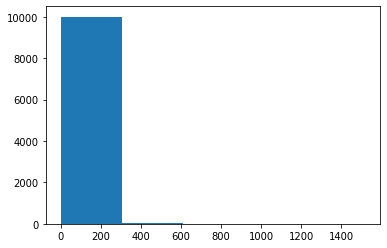

In [29]:
# Plot the histogram of sentence length
plt.hist(txt_length, 5)
plt.show()

In [30]:
# Observing labels
df['label'].value_counts()

0    8206
1     906
3     435
4     369
2     142
Name: label, dtype: int64

In [31]:
df['label'] = df['label'].astype(str)
df['label']

0        0
1        0
2        4
3        0
4        0
        ..
10053    4
10054    0
10055    0
10056    0
10057    0
Name: label, Length: 10058, dtype: object

In [32]:
# Missing data
#checking missing values
print('Is null: \n', df.isnull().sum() )


Is null: 
 docID        0
keyword      0
country      0
paragraph    0
label        0
dtype: int64


0    9112
1     946
Name: label, dtype: int64


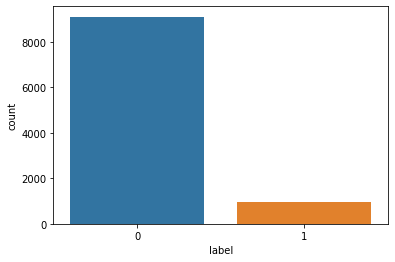

In [33]:
# Turning labels to binary

label_dic = {'0':0,
             '1':0,
             '2':1,
             '3':1,
             '4':1}
df['label'] = df['label'].map(label_dic)
print(df['label'].value_counts())
sns.countplot(x='label', data=df)
plt.show()

# Developing models

In [34]:
# Splitting the data into training (80%) and test set(20%)
from sklearn.model_selection import train_test_split
X = df['paragraph']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split (X, y, train_size = 0.8, random_state = 42, shuffle = True, stratify=y)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)
print(y_train.value_counts())

Shapes of X_train, y_train:  (8046,) (8046,)
Shapes of X_test, y_test:  (2012,) (2012,)
0    7289
1     757
Name: label, dtype: int64


## **Classic ML models**

### Text representation

In [35]:
!pip install stop-words
from stop_words import get_stop_words
stopwords = get_stop_words('en')
from textblob import Word
import re
import nltk
nltk.download('wordnet')

#BOW based approaches
nlp.init_sims(replace=True) # calling for using syn0norm

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
# Tokenize, and apply word vector averaging to tokenized text
import nltk
nltk.download('punkt')
import logging
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
# Tokenize texts into words
X_train_tokenized = X_train.apply(lambda x: w2v_tokenize_text(x)).values
X_test_tokenized = X_test.apply(lambda x: w2v_tokenize_text(x)).values

# Embed words into number
X_train_word_average = word_averaging_list(nlp,X_train_tokenized)
X_test_word_average = word_averaging_list(nlp,X_test_tokenized)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).


### Creating models

In [37]:
# Printing model performance 
def printing_eval_scores (y_true, y_pred):
  print('accuracy score: {}'.format(sklearn.metrics.accuracy_score(y_true, y_pred)))
  print('precision score: {}'.format(sklearn.metrics.precision_score(y_true, y_pred, average = 'weighted', zero_division=1)))
  print('recall score: {}'.format(sklearn.metrics.recall_score(y_true, y_pred,  average = 'weighted', zero_division=1)))
  print('F1 score: {}'.format(f1_score(y_true, y_pred,  average = 'macro', zero_division=1)))
  print('\nConfusion Matrix:\n', confusion_matrix(y_true, y_pred))
  print('\n', classification_report(y_true, y_pred))

# Get the measurements of ROC curve for each model
def get_roc_cuve (y_true, y_pred):
  #cmatrix = confusion_matrix(y_true, y_pred)

  # Get arrays of FPR and recall using roc_curve
  FPR, recall, threshold = sklearn.metrics.roc_curve(y_true, y_pred)
  #print('FPR:', FPR)
  
  # Get auc score
  auc = sklearn.metrics.auc(FPR, recall)
  roc = { 'fpr': FPR, 'tpr': recall, 'auc': auc}
  return roc

In [38]:
# Define a function for creating over sampling 
def score_model(name,model):
    cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)

    oversampler = SMOTE(random_state=42)
    #oversampler = RandomOverSampler(sampling_strategy='minority')
    scores = []
    f1_scores = []
    
    ## on training set, do cv
    for train_fold_index, val_fold_index in cv.split(X_train_word_average, y_train):
        # Get the training data
        X_train_fold, y_train_fold = X_train_word_average[train_fold_index], y_train.iloc[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X_train_word_average[val_fold_index], y_train.iloc[val_fold_index]

        # Upsample only the data in the training section
        X_train_fold_upsample, y_train_fold_upsample = oversampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
        # Fit the model on the upsampled training data
        model.fit(X_train_fold_upsample, y_train_fold_upsample)
        # Score the model on the (non-upsampled) validation data
        score = accuracy_score(y_val_fold, model.predict(X_val_fold)) #  average= 'weighted' for F1
        f1 = sklearn.metrics.f1_score(y_val_fold, model.predict(X_val_fold),  average = 'macro', zero_division=1)  #f1_scores.append(f1_score)
        scores.append(score)
        f1_scores.append(f1)
        
    print('Average of acuracy score in training: %s' % np.array(scores).mean())
    print('Average of Macro F1-score in training: %s' % np.array(f1_scores).mean())

    ## on test set
    y_pred = model.predict(X_test_word_average)
    test_score = accuracy_score( y_test,y_pred)
    macro_f1_test = f1_score(y_test, y_pred,  average = 'macro', zero_division=1)
    printing_eval_scores (y_test, y_pred)
    roc = get_roc_cuve(y_test, y_pred)
    report_scores = {'accuracy_folds':np.array(scores),'accuracy_test':test_score, 'macro_f1_test': macro_f1_test, 'y_predicted':y_pred, 'roc': roc }
    return report_scores #(np.array(scores),test_score,y_pred )       #(np.array(scores).mean(), np.array(scores).std())

Average of acuracy score in training: 0.7895843643480578
Average of Macro F1-score in training: 0.6328994844641667
accuracy score: 0.794234592445328
precision score: 0.9020001923515237
recall score: 0.794234592445328
F1 score: 0.6387422020831454

Confusion Matrix:
 [[1459  364]
 [  50  139]]

               precision    recall  f1-score   support

           0       0.97      0.80      0.88      1823
           1       0.28      0.74      0.40       189

    accuracy                           0.79      2012
   macro avg       0.62      0.77      0.64      2012
weighted avg       0.90      0.79      0.83      2012

LR: 0.789584 (0.014373)
Average of acuracy score in training: 0.8998255928415088
Average of Macro F1-score in training: 0.6102776456912669
accuracy score: 0.8941351888667992
precision score: 0.8676334767662144
recall score: 0.8941351888667992
F1 score: 0.5925433288045157

Confusion Matrix:
 [[1765   58]
 [ 155   34]]

               precision    recall  f1-score   support

  

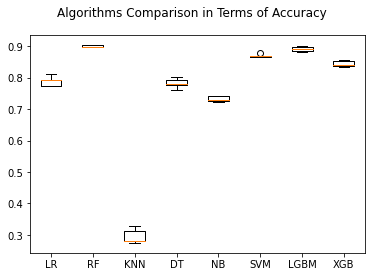

In [39]:
# Running all models together
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=700)))
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(decision_function_shape='ovo', probability=True)))
models.append(('LGBM', LGBMClassifier(objective= 'binary')))
models.append(('XGB', XGBClassifier(eval_metric="mlogloss", objective = "reg:logistic") ))


# evaluate each model in turn
results = []
score_test = []
macro_f1 = {}
names = []
rocs = {}
report_scores_all = {}
for name, model in models:
  #fold_scores, test_score = score_model(model)
  report_scores = score_model(name, model)
  report_scores_all[name] = report_scores
  #results.append(fold_scores)
  #score_test.append(test_score)
  results.append(report_scores['accuracy_folds'])
  score_test.append(report_scores['accuracy_test'])
  macro_f1[name] = (report_scores['macro_f1_test'])
  rocs[name] = (report_scores['roc'])
  names.append(name)
  # msg = "%s: %f (%f)" % (name, fold_scores.mean(), fold_scores.std())
  msg = "%s: %f (%f)" % (name, report_scores['accuracy_folds'].mean(), report_scores['accuracy_folds'].std())
  print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithms Comparison in Terms of Accuracy')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

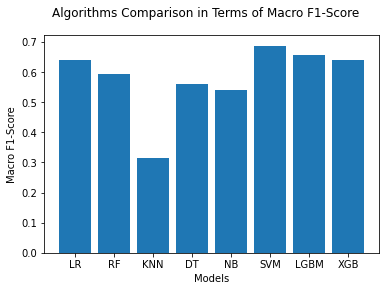

In [40]:
# boxplot algorithm comparison in terms of Macro F1-Score
fig = plt.figure()
fig.suptitle('Algorithms Comparison in Terms of Macro F1-Score')
ax = fig.add_subplot(111)
plt.bar(macro_f1.keys(), macro_f1.values())
plt.ylabel('Macro F1-Score')
plt.xlabel('Models')
ax.set_xticklabels(names)
plt.show()

#**Visualize all models with ROC curves**

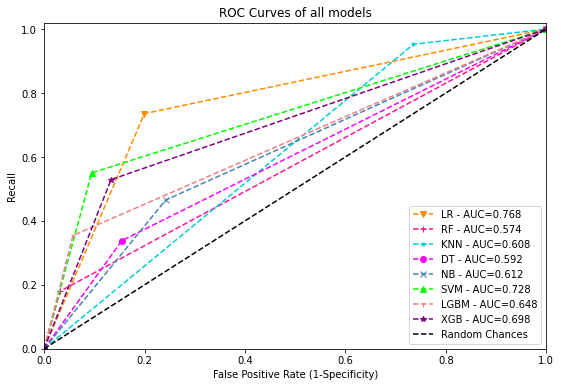

In [42]:
def graph_multi_ROC (rocs):
  # Set color for each model
  colors = {'LGBM': 'lightcoral','LR': 'darkorange', 'SVM':'lime', 'NB': 'steelblue',
            'XGB': 'purple','DT': 'magenta','RF': 'deeppink','KNN': 'darkturquoise',
            'BERT': 'darkred', 'GPT': 'blue'}
  # Set marker for each model          
  markers = {'LGBM':'1--','LR': 'v--', 'SVM': '^--', 'XGB': '*--', 'DT': 'o--', 'RF': '+--', 'KNN': '.--', 'NB': 'x--', 'BERT':'<--', 'GPT': '>--'}
  
  plt.figure(figsize=(9,6))
  for model in rocs:
    plt.plot( rocs[model]['fpr'], rocs[model]['tpr'], markers[model], color=colors[model], label= model+' - AUC=' + str(rocs[model]['auc'].round(3)) )
  
  plt.plot([0,1], [0,1], 'k--', label='Random Chances')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.02])
  plt.ylabel('Recall')
  plt.xlabel('False Positive Rate (1-Specificity)')
  plt.legend(loc='lower right') 
  plt.title( 'ROC Curves of all models')
  plt.show()

graph_multi_ROC(rocs)

In [41]:
report_scores_all

{'DT': {'accuracy_folds': array([0.77701863, 0.76134245, 0.80174021, 0.77874456, 0.79366066]),
  'accuracy_test': 0.7972166998011928,
  'macro_f1_test': 0.5609167465425168,
  'roc': {'auc': 0.591692860480573,
   'fpr': array([0.        , 0.15523862, 1.        ]),
   'tpr': array([0.        , 0.33862434, 1.        ])},
  'y_predicted': array([0, 0, 0, ..., 1, 0, 0])},
 'KNN': {'accuracy_folds': array([0.27453416, 0.28029832, 0.31261653, 0.28091983, 0.32691112]),
  'accuracy_test': 0.3290258449304175,
  'macro_f1_test': 0.31356047855160807,
  'roc': {'auc': 0.6083901470626649,
   'fpr': array([0.        , 0.73560066, 1.        ]),
   'tpr': array([0.        , 0.95238095, 1.        ])},
  'y_predicted': array([0, 1, 1, ..., 1, 1, 1])},
 'LGBM': {'accuracy_folds': array([0.90124224, 0.88315724, 0.89869484, 0.88564326, 0.8918583 ]),
  'accuracy_test': 0.8871769383697813,
  'macro_f1_test': 0.654610036881505,
  'roc': {'auc': 0.6484499937599224,
   'fpr': array([0.        , 0.05759737, 1.   

In [43]:
# Export performance to a txt file
txtfile = open('results.txt','w')
for i in report_scores_all.keys():
  txtfile.write(str(i) + '=' + str(report_scores_all[i])+'\n')
  #print(report_scores_all[i])
txtfile.close()